# Time Series Forecasting

In this tutorial, we will use `numpyro` to do forecasting. Specifically, we will replicate the **Seasonal, Global Trend (SGT)** model in [Rlgt: Bayesian Exponential Smoothing Models with Trend Modifications](https://cran.r-project.org/web/packages/Rlgt/index.html) package. Data is the famous **lynx** time series, which contains annual numbers of lynx trappings from 1821 to 1934 in Canada.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as np
from jax import lax, random, vmap
from jax.config import config; config.update("jax_platform_name", "cpu")

import numpyro.distributions as dist
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.distributions.util import softmax
from numpyro.handlers import sample, seed, substitute, trace
from numpyro.hmc_util import initialize_model
from numpyro.mcmc import mcmc

## Data

First, let's import and take a look at the dataset.

Length of time series: 114


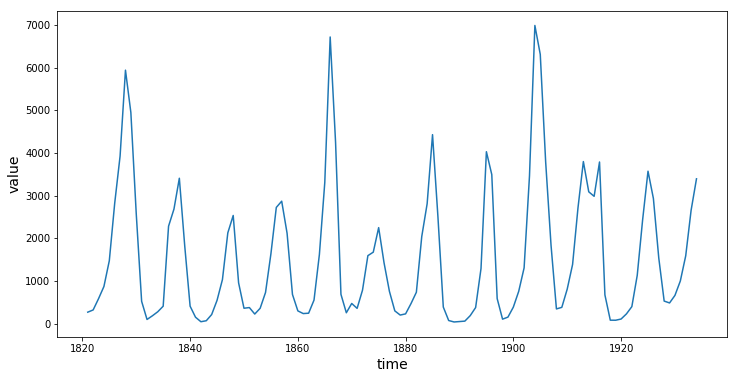

In [2]:
lynx = pd.read_csv("lynx.csv", index_col=0)
data = lynx["value"].values
print("Length of time series:", data.shape[0])
plt.figure(figsize=(12, 6))
plt.plot(lynx["time"], data)
plt.xlabel("time", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.show()

So the time series has length is 114 and by looking at the plot, we can observe the [seasonality](https://en.wikipedia.org/wiki/Seasonality) - a similar pattern occurs after a specific period of time (yearly, quarterly, monthly,...). In this tutorial, we will use the first 80 values for training and the last 34 values for testing.

In [3]:
y_train, y_test = data[:80], data[80:]

## Model

The model we are going to use is called **Seasonal, Global Trend**, which is famous for performing very well on 3003 time series of the [M-3 competition](https://forecasters.org/resources/time-series-data/m3-competition/):

$$
\begin{equation}
\text{exp_val}_{t} = \left(\text{level}_{t-1} + \text{coef_trend} \times \text{level}_{t-1}^{\text{pow_trend}}\right) \times \text{s}_t,\\
\sigma_{t} = \sigma \times \text{exp_val}_{t}^{\text{powx}} + \text{offset},\\
y_{t} \sim \text{StudentT}(\nu, \text{exp_val}_{t}, \sigma_{t}),\\
\end{equation}
$$
where `level` and `s` follows the following recursion rules:
$$
\begin{equation}
\text{level}_{t} = \text{level_sm} \times \frac{y_{t}}{\text{s}_{t}} + (1 - \text{level_sm}) \times \text{level}_{t-1},\\
\text{s}_{t + \text{seasonality}} = \text{s_sm} \times \frac{y_{t}}{\text{level}_{t}} + (1 - \text{s_sm}) \times \text{s}_{t}.\\
\end{equation}
$$

A more detailed explanation for SGT model can be found in [this vignette](https://cran.r-project.org/web/packages/Rlgt/vignettes/GT_models.html) from the authors of Rlgt package. Here we summarize the core ideas of this model:
+ [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution), which has heavier tails than normal distribution, is used for the likelihood.
+ The expected value `exp_val` consists of a trending component and a seasonal component:
  - The trend is governed by the map $x \mapsto x + ax^b$, where $x$ is `level`, $a$ is `coef_trend`, and $b$ is `pow_trend`. Note that when $b \sim 0$, the trend is linear with $a$ is the slope, and when $b \sim 1$, the trend is exponential with $a$ is the rate. So that function can cover a large family of trend.
  - When time changes, `level` and `s` are updated to new values. Coefficients `level_sm` and `s_sm` are used to make the transition smoothly.
+ When `powx` is near $0$, the error $\sigma_t$ will be nearly constant while when `powx` is near $1$, the error will be propotional to the expected value.

Before making the model, we want to remark that `level` and `s` are updated recursively while we collect the expected value at each time step. Doing so using Python `for` loop will endure a long compiling time for the model, so we use `jax.lax.scan` instead. A detailed explanation for using this utility can be found in [lax.scan documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html#jax.lax.scan). Here we use it to collect expected values while the pair `(level, s)` plays the role of carrying state.

In [4]:
def scan_exp_val(y, level_init, s_init, level_sm, s_sm, coef_trend, pow_trend):
    def scan_fn(carry, y_t):
        level, s = carry
        exp_val = (level + coef_trend * level ** pow_trend) * s[0]
        exp_val = np.clip(exp_val, a_min=0)
        level = level_sm * y_t / s[0] + (1 - level_sm) * level
        new_s = s_sm * y_t / level + (1 - s_sm) * s[0]
        s = np.concatenate([s[1:], new_s[None]], axis=0)
        return (level, s), exp_val

    (last_level, last_s), exp_vals = lax.scan(scan_fn, (level_init, s_init), y)
    return exp_vals, last_level, last_s

Putting the above technical note aside, we are ready to make the above model in *NumPyro* language. In NumPyro, we use the statement `sample(name, prior)` to declare a latent random variable with a corresponding `prior`.

In [5]:
def sgt(y, seasonality):
    # heuristically, standard derivation of Cauchy prior depends on the max value of data
    cauchy_sd = np.max(y) / 150

    nu = sample("nu", dist.Uniform(2, 20))
    powx = sample("powx", dist.Uniform(0, 1))
    sigma = sample("sigma", dist.HalfCauchy(cauchy_sd))
    offset_sigma = sample("offset_sigma", dist.TruncatedCauchy(low=1e-10, loc=1e-10,
                                                               scale=cauchy_sd))

    coef_trend = sample("coef_trend", dist.Cauchy(0, cauchy_sd))
    pow_trend_beta = sample("pow_trend_beta", dist.Beta(1, 1))
    # pow_trend takes values from -0.5 to 1
    pow_trend = 1.5 * pow_trend_beta - 0.5

    level_sm = sample("level_sm", dist.Beta(1, 2))
    s_sm = sample("s_sm", dist.Uniform(0, 1))
    init_s = sample("init_s", dist.Cauchy(np.zeros(seasonality), 4))
    s_init = softmax(init_s) * seasonality
    level_init = y[0] / s_init[0]
    s_init = np.concatenate([s_init[1:], s_init[:1]], axis=0)

    exp_val, last_level, last_s = scan_exp_val(
        y[1:], level_init, s_init, level_sm, s_sm, coef_trend, pow_trend)
    omega = sigma * exp_val ** powx + offset_sigma
    sample("y", dist.StudentT(nu, exp_val, omega), obs=y[1:])
    # we return last `level` and last `s` for forecasting
    return last_level, last_s

Note that all prior parameters are retrieved from [this file](https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/rlgtcontrol.R) from original source. In addition, the initial values of `s` are transformed from unconstrained values with Cauchy priors by using `softmax` operator. Hence, each value in `s` represents seasonal propotion (over the whole season) at the particular time of that value. Here, following [the original implementation](https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/src/stan_files/SGT.stan#L73), we change the scale of
constrained values by multiplying them with `seasonality`:
```python
...     s_init = softmax(init_s) * seasonality
```

## Inference

First, we want to choose a good value for `seasonality`. Following [the demo in Rlgt](https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/demo/lynx.R), we will set `seasonality=38`. Indeed, this value can be guessed by looking at autocorrelation of the training data:

In [6]:
print("Lag values sorted according their autocorrelation values:\n") 
print(np.argsort(autocorrelation(y_train))[::-1])

Lag values sorted according their autocorrelation values:

[ 0 67 57 38 68  1 29 58 37 56 28 10 19 39 66 78 47 77  9 79 48 76 30 18
 20 11 46 59 69 27 55 36  2  8 40 49 17 21 75 12 65 45 31 26  7 54 35 41
 50  3 22 60 70 16 44 13  6 25 74 53 42 32 23 43 51  4 15 14 34 24  5 52
 73 64 33 71 72 61 63 62]


HMC algorithms require a potential function and initial parameters. The utility `initialize_model` will help us convert our `sgt` model to a potential function with inputs are unconstrained values of latent variables. Because the input lies in unconstrained space, we need the utility `constrain_fn` to transform unconstrained parameters back to the original constrained domain of these parameters.

In [7]:
init_params, potential_fn, constrain_fn = initialize_model(
    random.PRNGKey(2), sgt, y_train, seasonality=38)

Now, let's run `mcmc` (using the default No-U-Turn Sampler algorithm) with $5000$ warmup steps and $5000$ sampling steps. The returned value will be a collection of $5000$ samples. We set `target_accept_prob=0.9` and `max_tree_depth=12` following the original implementation in Rlgt package.

In [8]:
samples = mcmc(num_warmup=5000, num_samples=5000,
               init_params=init_params, potential_fn=potential_fn, constrain_fn=constrain_fn,
               target_accept_prob=0.9, max_tree_depth=12)

sample: 100%|██████████| 5000/5000 [00:14<00:00, 347.24it/s, 127 steps of size 3.22e-02. acc. prob=0.88]




                           mean         sd       5.5%      94.5%      n_eff       Rhat
          coef_trend     124.41     284.83     -97.35     345.30     726.13       1.00
           init_s[0]      -0.39       0.69      -1.43       0.77     738.20       1.00
           init_s[1]      -1.04       0.70      -2.17       0.03     728.55       1.00
           init_s[2]      -0.84       0.69      -1.98       0.20     706.50       1.00
           init_s[3]      -0.47       0.67      -1.49       0.62     708.48       1.00
           init_s[4]       0.04       0.67      -1.03       1.08     702.39       1.00
           init_s[5]       0.83       0.67      -0.21       1.88     701.55       1.00
           init_s[6]       1.30       0.66       0.28       2.38     699.54       1.00
           init_s[7]       1.81       0.66       0.82       2.90     710.47       1.00
           init_s[8]       1.43       0.66       0.41       2.52     699.61       1.00
           init_s[9]       0.54       0.6

## Forecasting

Given `samples` from `mcmc`, we want to do forecasting for the testing dataset `y_test`. First, we will make some utilities to do forecasting given a sample. Note that to retrieve the last `level` and last `s` value, we substitute a sample to the model:
```
...    level, s = substitute(sgt, asample)(*args, **kwargs)`
```
where `args` and `kwargs` are arguments of `sgt` model (which are `y_train` and `seasonality=38`).

In [41]:
# Ref: https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/forecast.rlgtfit.R
def sgt_forecast(asample, future, *args, **kwargs):
    pow_trend = 1.5 * asample["pow_trend_beta"] - 0.5
    level, s = substitute(sgt, asample)(*args, **kwargs)
    for t in range(future):
        exp_val = (level + asample["coef_trend"] * level ** pow_trend) * s[0]
        exp_val = np.clip(exp_val, a_min=0)
        omega = asample["sigma"] * exp_val ** asample["powx"] + asample["offset_sigma"]
        yf = sample("yf[{}]".format(t), dist.StudentT(asample["nu"], exp_val, omega))
        yf = np.clip(yf, a_min=1e-30)
        # different from the original implementation, we use exp_val here instead of yf
        level_tmp = asample["level_sm"] * exp_val / s[0] + (1 - asample["level_sm"]) * level
        level = np.where(level_tmp > 1e-30, level_tmp, level)
        # s is repeated instead of being updated
        s = np.concatenate([s[1:], s[:1]], axis=0)


def forecast(rng, forecast_model, asample, future, *args, **kwargs):
    forecast_model = seed(forecast_model, rng)
    forecast_trace = trace(forecast_model).get_trace(asample, future, *args, **kwargs)
    return {name: np.clip(site["value"], a_min=1e-30)
            for name, site in forecast_trace.items() if "yf" in name}

Then, we can use [jax.vmap](https://jax.readthedocs.io/en/latest/jax.html#jax.vmap) to get prediction given a collection of samples. This is extremely fast comparing to using for-loop to collect predictions, each with a sample.

In [55]:
rngs = random.split(random.PRNGKey(3), samples["nu"].shape[0])
forecast_marginal = vmap(lambda rng, asample: forecast(
    rng, sgt_forecast, asample, future=len(y_test), y=y_train, seasonality=38))(rngs, samples)
forecast_values = np.stack(list(forecast_marginal.values()), axis=1)

Finally, let's get sMAPE, mean square error of the prediction and visualize the result with the mean prediction and the 89% highest posterior density interval (HPDI).

In [56]:
y_pred = np.mean(forecast_values, axis=0)
sMAPE = np.mean(np.abs(y_pred - y_test) / (y_pred + y_test)) * 200
msqrt = np.sqrt(np.mean(y_pred - y_test) ** 2)
print("sMAPE: {:.2f}, rmse: {:.2f}".format(sMAPE, msqrt))

sMAPE: 66.30, rmse: 260.92


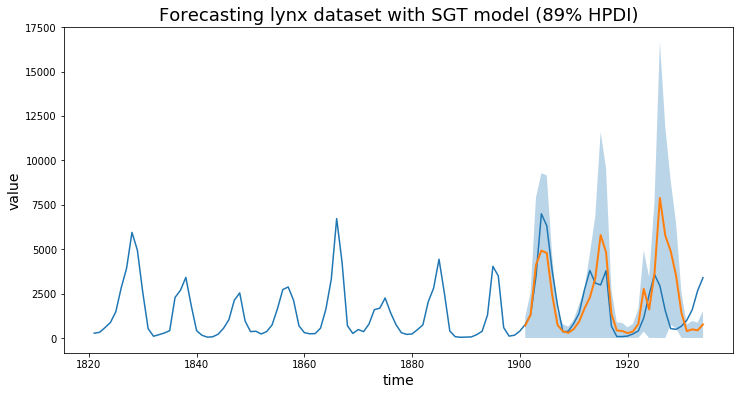

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(lynx["time"], data)
t_future = lynx["time"][80:]
hpd_low, hpd_high = hpdi(forecast_values)
plt.plot(t_future, y_pred, lw=2)
plt.fill_between(t_future, hpd_low, hpd_high, alpha=0.3)
plt.title("Forecasting lynx dataset with SGT model (89% HPDI)", fontsize=18)
plt.xlabel("time", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.show()

#### use median

sMAPE: 69.19, rmse: 281.88


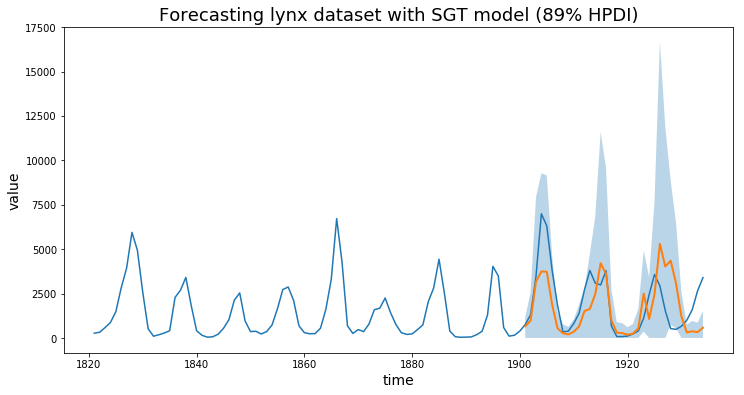

In [60]:
import numpy as onp

y_pred = onp.median(forecast_values, axis=0)
sMAPE = np.mean(np.abs(y_pred - y_test) / (y_pred + y_test)) * 200
msqrt = np.sqrt(np.mean(y_pred - y_test) ** 2)
print("sMAPE: {:.2f}, rmse: {:.2f}".format(sMAPE, msqrt))

plt.figure(figsize=(12, 6))
plt.plot(lynx["time"], data)
t_future = lynx["time"][80:]
hpd_low, hpd_high = hpdi(forecast_values)
plt.plot(t_future, y_pred, lw=2)
plt.fill_between(t_future, hpd_low, hpd_high, alpha=0.3)
plt.title("Forecasting lynx dataset with SGT model (89% HPDI)", fontsize=18)
plt.xlabel("time", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.show()

## Acknowledgements

We would like to thank Slawek Smyl for many helpful resources and suggestions. Fast inference would not have been possible without the support of JAX & XLA teams, so we also wish to thank them for providing such a great framework for us to build on.

## References

[1] `Rlgt: Bayesian Exponential Smoothing Models with Trend Modifications`,</br>&nbsp;&nbsp;&nbsp;&nbsp;
Slawek Smyl, Christoph Bergmeir, Erwin Wibowo, To Wang Ng, Trustees of Columbia University